# Studying artists' career to understand the patterns and their determinants

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import unicodedata
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
# %matplotlib inline

In [2]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
global color_h, color_f, color_b, PLOTDIM, FREQYEARS
color_h = "gold"
color_f = "royalblue"
color_b = "lightgray"
PLOTDIM = (9,6)
FREQYEARS = 10
my_cm = LinearSegmentedColormap.from_list("colormap", [color_h, color_f], N=100)

In [3]:
matplotlib.font_manager._rebuild()
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.sans-serif'] = 'Roboto'
plt.rcParams['font.weight'] = 500
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [4]:
def linearize(str1):
    d = [str1[0]] + [str1[i] for i in range(1,len(str1)) if str1[i-1] != str1[i]]
    return ''.join(d)

#### Import data

In [5]:
raw_authors = pd.read_csv('../data/ALL_AUTHORS (live_work + clean nat).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art = pd.read_csv('../data/ALL_ARTWORKS (for stats use ONLY).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art['groupcol'] = raw_art['related'].fillna(value='') + raw_art['acquisition'].fillna(value='')

In [6]:
# On travaille en points de contact
art = raw_art.groupby(['authors', 'collection', 'acquisition_year']).first().reset_index()
art = art[art['acquisition_year'] > 1945]
raw_authors['live_and_work'] = raw_authors['live_and_work'].replace({'0': None})
print(art.shape, raw_authors.shape)

(71660, 117) (35958, 23)


In [139]:
museums = pd.read_csv('../data/MUSEUMS_AND_VISITORS.csv', encoding='utf-8', sep=',', low_memory=False)

In [143]:
art[art.collection.str.contains("Fonds municipal d'art contemporain")]

,authors,collection,acquisition_year,_id,ensemble_id,nb_elements,related,type,recap_inventory,recap_title,recap_nature,title_notice,title_list,title_ensemble,collection_department,dimensions_additional,inscriptions,expositions_without_current,expositions,bibliography,copyright,author_in_common,is_dissoc,acquisition_mode,recap_copyright,date_creation,domain,domain_leaf,domain_deno_for_grid,domain_description_mst,comments,recap_description,recap_authors,authors_notice,authors_list,dimensions,recap_dimensions,acquisition,inventory,inventory_for_grid,key_words_thema,rights_management_leaf,default_tooltip_ua_description,authors_name_complement,authors_site,authors_documents,authors_video,authors_nationality,authors_birth_death,live_and_work,author_bibliography,recap_nationality,recap_name_complement,recap_birth_death,recap_live_and_work,recap_author_bibliography,recap_live_work,nb_images,medias,recap_image_unavailable,localisation_if_deposit,number_provisory,key_words_icono,image_unavailable,title_serial,key_words_movement,title_attributed,creation_stage,domain_deno,deposit_number,deposit_number_for_grid,tirage_design,number_exhibition,realisation_location,recap_multi,dimensions_without_margin,tirage,collaborators_design,authors_live_work,collaborators,tirage_photo,title_old,number_entry,production_circumstances,subtitle,number_identification,number_artist_studio,title_other,text_notes,title_old_by_artist,number_document,title_collection,number_depositary_or_loaner,recap_bibliography,ensemble,old_owners,recap_title_trad,number_artist,trans_title_attributed,number_isbn,number_succession,trans_subtitle,number_issn,mnam_mnr,trans_title_serial,number_catalogue,number_frame,trans_title_ensemble,trans_title_other,trans_title_old,old_attributions,acquisition_mode_clean,Gender,age_at_acquisition,nationality,is_first,groupcol,collection_category
14,110000000000192,Fonds municipal d'art contemporain de la Ville...,2014.0,2.000000e+14,NaN,NaN,NaN,individual,NaN,NaN,NaN,AVL Ville,AVL Ville,NaN,Arts Plastiques,NaN,S.N.R. : [Signature sur une étiquette] / AVL 0...,NaN,NaN,NaN,© Atelier Van Lieshout,a,NaN,Achat,NaN,2000,Estampe,Estampe,Estampe,Impression laser rehaussée à l'aquarelle et a...,NaN,NaN,NaN,ATELIER VAN LIESHOUT,ATELIER VAN LIESHOUT,NaN,NaN,Achat à Jousse Entreprise en 2014,CM2014.2.1,CM2014.2.1,NaN,..Droits directs par l'artiste,Impression laser rehaussée à l'aquarelle et a...,NaN,<a href='http://www.ateliervanlieshout.com' re...,NaN,NaN,NaN,NaN,Vit et travaille à Rotterdam (Pays-Bas),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,90000000491686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ed. 1/5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Achat,non renseigné,NaN,NaN,0.0,Achat à Jousse Entreprise en 2014,A
58,110000000000223,Fonds municipal d'art contemporain de la Ville...,1953.0,2.000000e+14,NaN,NaN,NaN,individual,NaN,NaN,NaN,Fleurs dans un vase,Fleurs dans un vase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domaine public,a,NaN,Don,NaN,s.d.,Peinture,Peinture,Peinture,Huile sur toile,NaN,NaN,NaN,Emile Jean-Baptiste Philippe BIN,BIN Emile Jean-Baptiste Philippe,46 x 38 cm,NaN,Don en 1953,CMP9568,CMP9568,NaN,..Domaine public,Huile sur toile,NaN,NaN,NaN,NaN,française,"Paris (France), 1825 - Paris (France), 1897",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Don,masculin,128.0,française,0.0,Don en 1953,A
59,110000000000223,Fonds municipal d'art contemporain de la Ville...,1988.0,2.000000e+14,NaN,NaN,NaN,individual,NaN,NaN,NaN,Portrait de Rollin,Portrait de Rollin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domaine public,a,NaN,Achat,NaN,s.d.,Peinture,Peinture,Peinture,Huile sur toile,NaN,NaN,NaN,Emile Jean-Baptiste Philippe BIN,BIN Emile Jean-Baptiste Philippe,120 

#### Encode collections into broader categories

In [8]:
art = art[pd.notnull(art['collection'])]
art['collection_category'] = None
for i, row in art.iterrows():
    museum = row['collection']
    if "frac" in museum.lower():
        cat = 'F'
    elif "musée national d'art moderne" in museum.lower():
        cat = 'P'
    elif "centre national des arts plastiques" in museum.lower():
        cat = 'C'
    elif "musée" in museum.lower():
        cat = 'M'
    else:
        cat = 'A'
    art.at[i, 'collection_category'] = cat

In [9]:
art['collection_category'].value_counts()

C    21387
M    17243
A    11324
P    10983
F    10723
Name: collection_category, dtype: int64

In [10]:
count = -1
for i, row in raw_authors.iterrows():
    count += 1
    if count % 5000 == 0:
        print(round(100*count/len(raw_authors)), '%')
    ind = row['Id artist']
    a = art[art['authors'].str.contains(str(ind))].sort_values('acquisition_year')
    raw_authors.at[i, 'acquisition_year'] = '|'.join([str(int(x)) for x in a['acquisition_year'].values])
    raw_authors.at[i, 'sequence'] = ''.join([x for x in a['collection_category'].values])

0 %
14 %
28 %
42 %
56 %
70 %
83 %
97 %


In [11]:
raw_authors['acquisition_year'] = raw_authors['acquisition_year'].replace({'': None})

In [12]:
raw_authors['first_aquisition'], raw_authors['last_aquisition_alive'] = None, None
for i, row in raw_authors.iterrows():
    dates = row['acquisition_year']
    if not pd.isnull(dates):
        dates = [int(d) for d in re.split('\|', dates)]
        raw_authors.at[i, 'art_count'] = len(dates)
        raw_authors.at[i, 'first_aquisition'] = min(dates)
        if not pd.isnull(row['Death year']):
            dates = [d for d in dates if d <= row['Death year']]
        if len(dates) > 0:
            raw_authors.at[i, 'last_aquisition_alive'] = max(dates)

In [13]:
# raw_authors['art_count'].value_counts()

In [85]:
authors = raw_authors[raw_authors['art_count'] >= 4]
authors = authors[authors['first_aquisition'] >= 1945]

In [86]:
for i, row in authors.iterrows():
    if pd.isnull(row['last_aquisition_alive']):
        authors.at[i, 'dead_career'] = 0
    elif (2018 - row['Birth year'] > 65) and (row['last_aquisition_alive'] < 2000):
        authors.at[i, 'dead_career'] = 1
    else:
        authors.at[i, 'dead_career'] = 2

In [87]:
# Count of alive but dead career artists
((authors['dead_career'] == 1) & pd.isnull(authors['Death year'])).sum()

635

In [88]:
authors = authors[pd.notnull(authors['Death year']) | (authors['dead_career'] == 1)]

In [89]:
# Dead or deed-career artists
len(authors)

2870

In [90]:
(authors['Death year'] - authors['Birth year']).mean()

76.65190156599553

In [20]:
# authors.to_csv("../data/DEAD AUTHORS (broadly).csv", encoding='utf-8', sep=',')
# authors = pd.read_csv("../data/DEAD AUTHORS (broadly).csv", encoding='utf-8', sep=',')

In [91]:
authors['linlength'] = authors['sequence'].apply(linearize).apply(len)

In [22]:
# authors = authors[authors['linlength'] < 50]

## Acquisition paths distance and clustering

In [92]:
ARTISTS_SEQUENCES = dict()
nmod = 5
for i, row in authors.iterrows():
    ARTISTS_SEQUENCES[row['Id artist']] = row['sequence']
ARTISTS = list(ARTISTS_SEQUENCES.keys())
convert = {'C': 0, 'P': 1, 'F': 2, 'M': 3, 'A': 4}
ranking = {'C': 1, 'P': 1, 'F': 0.5, 'M': 0.1, 'A': 0.1}

#### Compute Markov Matrix

In [130]:
def compute_markov(art_sequences):
    markov = np.zeros((nmod, nmod))
    count = np.zeros(nmod)
    for artist in list(art_sequences.keys()):
        path = art_sequences[artist]
        for i in range(1, len(path)):
            markov[convert[path[i-1]], convert[path[i]]] += 1
            count[convert[path[i-1]]] += 1
    for i in range(nmod):
        if count[i] == 0:
            markov[i,i] = 1
            count[i] = 1
    markov = markov / count[:,None]
    return markov

In [131]:
markov = compute_markov(ARTISTS_SEQUENCES)
penalty = markov.mean()
print(markov)

[[0.4122273  0.09791984 0.04870624 0.18696093 0.25418569]
 [0.17227488 0.41658768 0.05308057 0.32582938 0.03222749]
 [0.21765146 0.15332835 0.34405385 0.25804039 0.02692595]
 [0.18356742 0.19676966 0.04101124 0.51783708 0.06081461]
 [0.36442024 0.0329022  0.00930338 0.13455866 0.45881552]]


#### Defining costs for edit distance

In [26]:
SUB_COST = 2
DEL_COST = 1
INS_COST = 1

In [27]:
def insertion_cost(i, j, str1, str2):
    if i == 1:
        return 1
    elif i-2 <= 0:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    else:
        return 1

In [28]:
def deletion_cost(i, j, str1, str2):
    if i == 1:
        return 1
    elif i-2 <= 0:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    else:
        return 1

In [29]:
def substitution_cost(i, j, str1, str2):
    if str1[i-1] == str2[j-1]:
        return 0
    elif i == 1:
        return 2
    elif str2[j-1] == str1[i-2]:
        return 0.5
    elif i >= len(str1):
        return 2
    elif str2[j-1] == str1[i]:
        return 0.5
    else:
        return 2

#### Lenvenshtein edit distance

In [30]:
def levenshtein(str1, str2):
    # en fait, Wagner–Fischer algorithm
    # http://www.inrg.csie.ntu.edu.tw/algorithm2014/homework/Wagner-74.pdf
    # str1 = linearize(str1)
    # str2 = linearize(str2)
    n = len(str1)
    m = len(str2)
    d = np.zeros((n+1, m+1))
    for i in range(n+1):
        d[i,0] = i
    for j in range(m+1):
        d[0,j] = j
    for i in range(1,n+1):
        for j in range(1,m+1):
            d[i,j] = min(
                d[i  ,j-1] + insertion_cost(i, j, str1, str2),    # Deletion cost
                d[i-1,j  ] + deletion_cost(i, j, str1, str2),     # Insertion cost
                d[i-1,j-1] + substitution_cost(i, j, str1, str2)) # Substition cost
    ldist = d[n,m] / max(n, m)
    return ldist

#### Needleman–Wunsch optimal matching

In [31]:
def needlemanwunsch(str1, str2):
    # https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm
    n = len(str1)
    m = len(str2)
    d = np.zeros((n+1, m+1))
    for i in range(n+1):
        d[i,0] = -i
    for j in range(m+1):
        d[0,j] = -j
    for i in range(1,n+1):
        for j in range(1,m+1):
            d[i,j] = max(
                d[i  ,j-1] + penalty,     # Deletion cost
                d[i-1,j  ] + penalty,     # Insertion cost
                d[i-1,j-1] + markov[convert[str1[i-1]], convert[str2[j-1]]]) # Substition cost
    ldist = d[n,m] / max(n, m)
    return ldist

#### Markov distribution distance

In [72]:
def markovdistance(mark1, mark2):
    n = len(mark1)
    ldist = np.zeros(n)
    for i in range(n):
        ldist[i] = np.linalg.norm(mark1[i]-mark2[i])
    return np.linalg.norm(ldist)

#### Sequence distance with various metrics

In [39]:
distance = np.zeros((len(ARTISTS_SEQUENCES), len(ARTISTS_SEQUENCES)))

for i, artist_source in enumerate(ARTISTS):
    if i % 500 == 0:
        print(round(100*i/len(ARTISTS_SEQUENCES)), '%')
    sequence_source = ARTISTS_SEQUENCES[artist_source]
    for j, artist_target in enumerate(ARTISTS):
        sequence_target = ARTISTS_SEQUENCES[artist_target]
        distance[i, j] = levenshtein(sequence_source, sequence_target)

0 %
28 %
55 %
83 %


#### Distance between Markov matrix of each sequence

In [73]:
distance_m = np.zeros((len(ARTISTS_SEQUENCES), len(ARTISTS_SEQUENCES)))

for i, artist_source in enumerate(ARTISTS):
    if i % 500 == 0:
        print(round(100*i/len(ARTISTS_SEQUENCES)), '%')
    src = {artist_source: ARTISTS_SEQUENCES[artist_source]}
    mrk_src = compute_markov(src)
    for j, artist_target in enumerate(ARTISTS):
        dst = {artist_target: ARTISTS_SEQUENCES[artist_target]}
        mrk_dst = compute_markov(dst)
        distance_m[i, j] = markovdistance(mrk_src, mrk_dst)

0 %
28 %
55 %
83 %


#### Clustering

In [74]:
NUM_CLUSTERS = 7
kmeans = cluster.KMeans(NUM_CLUSTERS, random_state=1234).fit(distance_m)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#### Plot

In [43]:
def plot_clusters(dataset, labels, centroids):
    fig, ax = plt.subplots(figsize=(7,7))

    pca = PCA(n_components=2, random_state=123)
    reduced_data = pca.fit_transform(dataset)
    reduced_centroids = pca.transform(centroids)
    x_min, x_max = reduced_data[:, 0].min() - .1, reduced_data[:, 0].max() + .1
    y_min, y_max = reduced_data[:, 1].min() - .1, reduced_data[:, 1].max() + .1

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
    # for i in range(len(reduced_data)): plt.annotate(dataset.index.tolist()[i], reduced_data[i])
    
    for i, c in enumerate(reduced_centroids):
        ax.annotate(str(i), c, size=16, ha='center', path_effects=[pe.withStroke(linewidth=4, foreground="w")])
    # plt.xlim(x_min, x_max)
    # plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

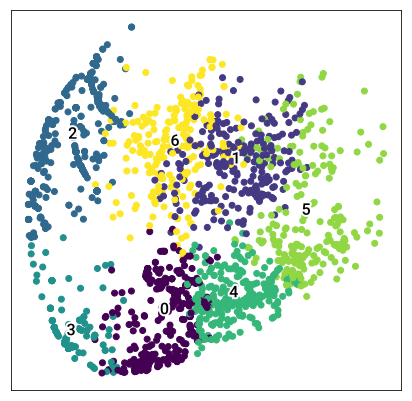

In [75]:
plot_clusters(distance_m, labels, centroids)

#### Inspect clusters

In [78]:
i = 1
print('Cluster n°%i containing:' % (i))
for j, artist in enumerate(ARTISTS):
    if labels[j] == i:
        sequence = ARTISTS_SEQUENCES[artist]
        print('  - %s' % (sequence))

Cluster n°1 containing:
  - PMCCAACCCAAC
  - CMCMCMACCPCMMPPMCC
  - PCMACACCCACCPCACM
  - PPPACCMPP
  - AMCACMMCMACCPMCMCMMMCFFFMFCFFAMFCCCMCCMMMPPM
  - CCCACPCF
  - CCACCPC
  - PMMCAPMPMMMPMMPPMPPAMMPMMM
  - APMCAMAP
  - CCPCAMM
  - CCAAPACAMAAMAMMM
  - CAMCPACMCCMMCMCCM
  - ACCMCCMMMAMMPAM
  - ACCPMPCMMPMPMMMPMPMFFFFFFMMCMFMFCCMMMFMAFACMACAMMAPCC
  - ACCCCPAM
  - CPCCCMCMCMPCCMACAC
  - MPMMAM
  - MPPCCCMMAMPMAMPCMACMPMMMMAPMM
  - PMACMCCACAPCCACCACMMPAMAAA
  - MPCPPCMPPCPPMCFMPFFMFCFMPACMPPMP
  - PPCCMMFFCFCCMFFFCPCFPCFPFMPCMFFAFMMACCMPMMCFMPMPMMMPMCP
  - CCCCPCCCCACCCM
  - PCCPCFCFFACCCCM
  - AMCPCCMMMMACCMMMC
  - CPCPCPMPMPMPMPMMMAMMMCMMMMMMMMM
  - AMAMCMACMMAAMMAMMCFFPCFMMM
  - CAPCAPACAAAAACAAC
  - CPPPCPCPCMPPCMMAMPMCFFFPFMMMPFMMPMMMMPM
  - CPCMPPPFPMMFMFFMMFMPFFFCMFMMMPCMMMMFPFPPFMFMCMFFFCPMMMMMMCPMMMPCFFAFFM
  - CPMPMPPMMPCMMMPPAPPCMPMCPPMMPPPMMMMMPMMPMMMMMMMMMM
  - MMAMMPCMMMMPMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM
  - CAPCACACACAAAAC
  - APACCACACACAA
  - CPMCMMCPMCMMMM

## Gender-oriented study of markov matrix

In [132]:
F_SEQUENCES, H_SEQUENCES = dict(), dict()
first_f, first_h = [], []
for i, row in authors.iterrows():
    if row['Gender'] == 'féminin':
        F_SEQUENCES[row['Id artist']] = row['sequence']
        first_f.append(row['sequence'][0])
    elif row['Gender'] == 'masculin':
        H_SEQUENCES[row['Id artist']] = row['sequence']
        first_h.append(row['sequence'][0])
F_ARTISTS = list(F_SEQUENCES.keys())
H_ARTISTS = list(H_SEQUENCES.keys())
first_f = pd.Series(first_f).value_counts(True).tolist()
first_h = pd.Series(first_h).value_counts(True).tolist()
print(len(F_ARTISTS), len(H_ARTISTS))

441 2429


In [133]:
markov_h = compute_markov(H_SEQUENCES)
markov_f = compute_markov(F_SEQUENCES)
print(markov_h, '\n\n', markov_f)

[[0.41550022 0.10313835 0.04714896 0.19080595 0.24340651]
 [0.16997389 0.41618799 0.05430809 0.32767624 0.03185379]
 [0.21278385 0.15054668 0.34735071 0.26408747 0.02523129]
 [0.17953098 0.19692499 0.04053424 0.52508153 0.05792825]
 [0.37496492 0.03480213 0.01038451 0.14229582 0.43755262]] 

 [[0.39197812 0.06563355 0.05834093 0.16317229 0.32087511]
 [0.19487179 0.42051282 0.04102564 0.30769231 0.03589744]
 [0.25675676 0.17567568 0.31756757 0.20945946 0.04054054]
 [0.22173275 0.19530103 0.04552129 0.44933921 0.08810573]
 [0.31990521 0.02488152 0.00473934 0.10189573 0.5485782 ]]


## Markov simulation

In [134]:
def simulate_path(first, matrix, length=15):
    choices = ['C', 'P', 'F', 'M', 'A']
    path = np.random.choice(choices, p=first)
    for i in range(length):
        p = matrix[convert[path[-1]]]
        path += np.random.choice(choices, p=p)
    return path

In [138]:
simulate_path(first_f, markov_f, length=15)

'CFCACCMMMMMAACPP'